In [1]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from tabulate import tabulate
import pandas as pd
import numpy as np
import warnings

In [2]:
# ปิดการแจ้งเตือนค่าคงที่
warnings.filterwarnings("ignore")

In [3]:
# Set the display options to prevent line wrapping and truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [4]:
data = pd.read_csv(r"csv\dataset_malwares.csv")

X = data.drop(['Name','Malware','SuspiciousImportFunctions','SuspiciousNameSection','TimeDateStamp'], axis=1)
y = data['Malware']

In [5]:
models = MLPClassifier()

In [6]:
def chi_square(k_mins, k_maxs, X, y, model, seed, cv):

    k_min = k_mins
    k_max = k_maxs

    results = []
    k_values = []
    accuracy_values = []

    f = open(f"result_text/chi_square/Chi2_MLP_seed{seed}.txt", "w+")
    
    for k in range(k_min, k_max):

        selector = SelectKBest(chi2, k=k)
        selector.fit(X, y)

        cols = selector.get_support(indices=True)

        X_select = X.iloc[:,cols]

        kf = KFold(n_splits=cv, random_state=seed, shuffle=True)

        scores = cross_val_score(model, X_select, y, cv=kf, scoring='accuracy')

        accuracy_score = scores.mean()

        k_values.append(k)
        accuracy_values.append(accuracy_score)
        results.append([k, accuracy_score])

        f.write('\n')
        f.write(f'ACC = {accuracy_score} K = {k} {X_select.columns.tolist()}')

    headers = ["K", "Accuracy"]
    f.write('\n')
    f.write(tabulate(results, headers, tablefmt="pretty"))
    f.close()

    plt.figure(figsize=(20, 6))
    plt.plot(k_values, accuracy_values, marker='.', linestyle='-')
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.title(f'Chi-Square - MLP, seed = {seed}')
    plt.xticks(range(k_min, k_max))
    plt.grid(True)

    save_path = f"result_graph/chi_square/Chi2_MLP_seed{seed}"
    plt.savefig(save_path)
    plt.close()

    return k_values, accuracy_values, k_max, selector

In [7]:
def main():

    f = open(f"result_text/average_result/Chi2_MLP_seed1-100.txt", "w+")    
    all_accuracy_values = []

    for seeds in range(1, 3):
        k_vals, acc_vals, k_maxs, selectors = chi_square(k_mins=1, k_maxs=6, X=X, y=y, model=models, seed=seeds, cv=2)
        all_accuracy_values.append(acc_vals)

    all_accuracy_values_array = np.array(all_accuracy_values)

    average_accuracies = all_accuracy_values_array.mean(axis=0)

    scores_ = np.log1p(selectors.scores_)
    features_score = pd.DataFrame(np.round(scores_,4))
    features_pvalue = pd.DataFrame(np.round(selectors.pvalues_,4))
    features = pd.DataFrame(X.columns)
    feature_score = pd.concat([features,features_score,features_pvalue],axis=1)

    feature_score.columns = ["Input_Features","Score","P_Value"]
    print(feature_score.nlargest(75,columns="Score"))
    f.write(feature_score.nlargest(75, columns="Score").to_string(index=False))

    average_results = list(zip(range(1, k_maxs + 1), average_accuracies))
    headers = ["K", "Average Accuracy 1-100 seed"]

    print('\n')
    print(tabulate(average_results, headers, tablefmt="pretty"))

    f.write('\n')
    f.write(tabulate(average_results, headers, tablefmt="pretty"))
    f.close()
    
    plt.figure(figsize=(20, 6))
    plt.plot(k_vals, average_accuracies, marker='.', linestyle='-')
    plt.xlabel('k')
    plt.ylabel('Average Accuracy 1-100 seed')
    plt.title(f'Chi-Square - MLP, Sample group 100 seeds')
    plt.xticks(range(1, k_maxs))
    plt.grid(True)
    save_path = f"result_graph/average_result/Chi2_MLP_seed1-100"
    plt.savefig(save_path)
    plt.show()

                  Input_Features    Score  P_Value
31                     ImageBase  34.9702      0.0
41                      CheckSum  27.3564      0.0
64                SectionMaxChar  26.5201      0.0
62         SectionMaxPointerData  25.7182      0.0
29           AddressOfEntryPoint  24.6698      0.0
20               NumberOfSymbols  24.5920      0.0
19          PointerToSymbolTable  24.5567      0.0
49                   LoaderFlags  23.0288      0.0
27         SizeOfInitializedData  22.7499      0.0
72  ImageDirectoryEntryException  22.6562      0.0
26                    SizeOfCode  22.6502      0.0
30                    BaseOfCode  22.5888      0.0
42                   SizeOfImage  21.6084      0.0
45            SizeOfStackReserve  21.5101      0.0
28       SizeOfUninitializedData  21.2990      0.0
50           NumberOfRvaAndSizes  20.7680      0.0
54             SectionMinRawsize  20.6853      0.0
56         SectionMinVirtualsize  20.4824      0.0
69     ImageDirectoryEntryExpor

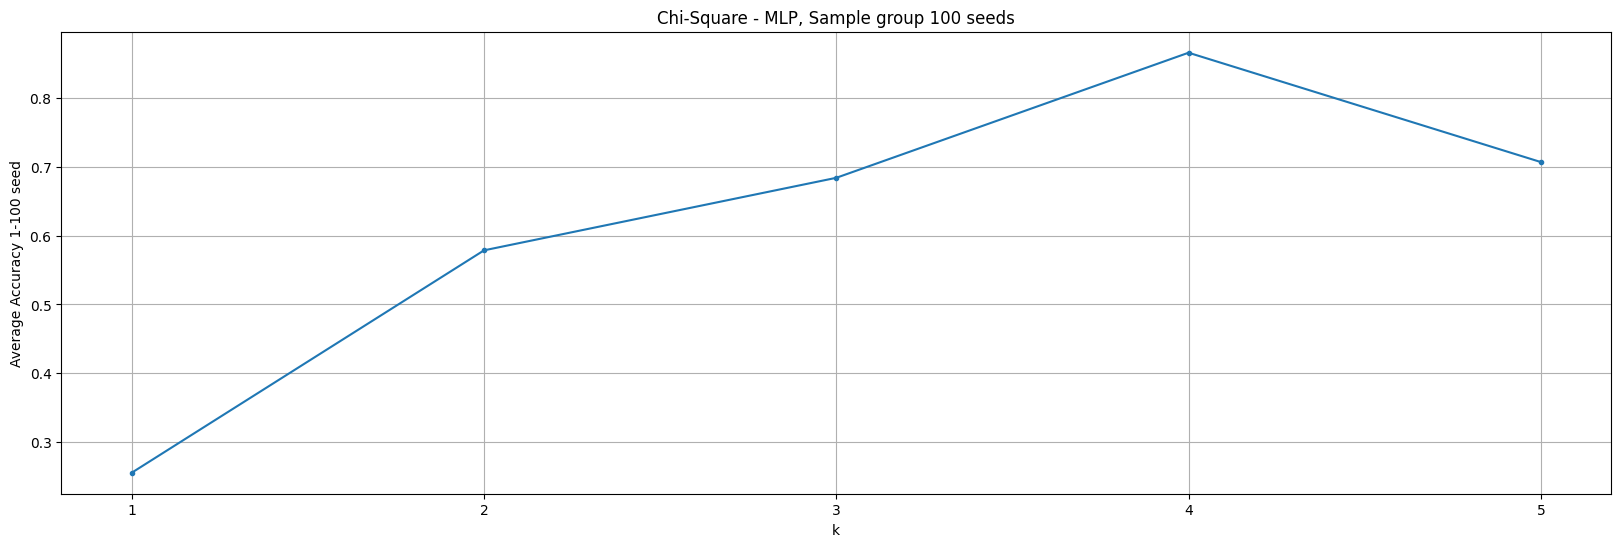

In [8]:
main()